In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm


In [3]:
COHORT_PATH = "/content/drive/MyDrive/permanent_data_folder/TCGA_BRCA_data/cohort_image_valid.csv"

cohort_df = pd.read_csv(COHORT_PATH)

print("Patients in image-valid cohort:", len(cohort_df))
cohort_df.head()


Patients in image-valid cohort: 193


,patient_id,time,event,rnaseq_path,slide_path
0,TCGA-A8-A07E,608.0,0,/content/drive/MyDrive/permanent_data_folder/T...,/content/drive/MyDrive/permanent_data_folder/T...
1,TCGA-D8-A146,643.0,0,/content/drive/MyDrive/permanent_data_folder/T...,/content/drive/MyDrive/permanent_data_folder/T...
2,TCGA-A8-A09K,912.0,0,/content/drive/MyDrive/permanent_data_folder/T...,/content/drive/MyDrive/permanent_data_folder/T...
3,TCGA-A2-A0YT,723.0,1,/content/drive/MyDrive/permanent_data_folder/T...,/content/drive/MyDrive/permanent_data_folder/T...
4,TCGA-C8-A130,370.0,0,/content/drive/MyDrive/permanent_data_folder/T...,/content/drive/MyDrive/permanent_data_folder/T...


In [4]:
missing = []

for _, row in cohort_df.iterrows():
    if not os.path.exists(row["rnaseq_path"]):
        missing.append(row["patient_id"])

print("Missing RNA-seq files:", len(missing))
missing[:5]


Missing RNA-seq files: 0


[]

In [5]:
example_path = cohort_df.iloc[0]["rnaseq_path"]
print(example_path)

example_df = pd.read_csv(example_path, sep="\t")
example_df.head()


/content/drive/MyDrive/permanent_data_folder/TCGA_BRCA_data/a9527be9-e865-4074-ae57-f3510e70c203/d6ca3b86-5a26-4467-b9a9-cb7fcc5a7316.rna_seq.augmented_star_gene_counts.tsv


,,,,,,,,# gene-model: GENCODE v36
gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
N_unmapped,NaN,NaN,2044055,2044055,2044055,NaN,NaN,NaN
N_multimapping,NaN,NaN,6172661,6172661,6172661,NaN,NaN,NaN
N_noFeature,NaN,NaN,2837406,40242343,40542223,NaN,NaN,NaN
N_ambiguous,NaN,NaN,7478537,1788861,1772103,NaN,NaN,NaN


In [6]:
def load_rnaseq_counts(tsv_path):
    df = pd.read_csv(
        tsv_path,
        sep="\t",
        comment="#",        # ✅ ignore metadata lines
        low_memory=False
    )

    # sanity check
    if "gene_id" not in df.columns:
        raise ValueError("gene_id column not found")

    # keep real genes only
    df = df[df["gene_id"].str.startswith("ENSG", na=False)]

    # protein-coding genes only
    df = df[df["gene_type"] == "protein_coding"]

    # keep gene_id and unstranded counts
    df = df[["gene_id", "unstranded"]]

    df = df.set_index("gene_id")

    return df


In [7]:
gene_matrices = []
patient_ids = []

for _, row in tqdm(cohort_df.iterrows(), total=len(cohort_df)):
    pid = row["patient_id"]
    path = row["rnaseq_path"]

    try:
        counts = load_rnaseq_counts(path)
        gene_matrices.append(counts)
        patient_ids.append(pid)
    except Exception as e:
        print(f"Failed RNA-seq for {pid}: {e}")


100%|██████████| 193/193 [01:55<00:00,  1.68it/s]


In [8]:
rnaseq_df = pd.concat(gene_matrices, axis=1)
rnaseq_df.columns = patient_ids

print("Gene matrix shape:", rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]


Gene matrix shape: (19962, 193)


,TCGA-A8-A07E,TCGA-D8-A146,TCGA-A8-A09K,TCGA-A2-A0YT,TCGA-C8-A130
gene_id,,,,,
ENSG00000000003.15,2400,3414,1743,1569,4079
ENSG00000000005.6,53,210,6,2,25
ENSG00000000419.13,1910,2108,1438,4142,2689
ENSG00000000457.14,1525,2100,2361,2945,911
ENSG00000000460.17,1242,560,400,779,714


In [9]:
X = rnaseq_df.T  # shape: (patients, genes)
X.shape


(193, 19962)

In [10]:
X_log = np.log1p(X)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

X_scaled.shape


(193, 19962)

In [12]:
from sklearn.decomposition import PCA

PCA_DIM = 128

pca = PCA(n_components=PCA_DIM, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("RNA-seq PCA shape:", X_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())


RNA-seq PCA shape: (193, 128)
Explained variance: 0.9245150155466599


In [13]:
SAVE_DIR = "/content/drive/MyDrive/permanent_data_folder/TCGA_BRCA_data/rnaseq_embeddings"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "X_rnaseq_pca.npy"), X_pca)
np.save(os.path.join(SAVE_DIR, "patient_ids.npy"), np.array(patient_ids))

print("Saved RNA-seq embeddings")


Saved RNA-seq embeddings


In [15]:
[v for v in globals().keys()]



['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__builtin__',
 '__builtins__',
 '_ih',
 '_oh',
 '_dh',
 'In',
 'Out',
 'get_ipython',
 'exit',
 'quit',
 '_',
 '__',
 '___',
 '_i',
 '_ii',
 '_iii',
 '_i1',
 'drive',
 '_i2',
 'os',
 'np',
 'pd',
 'tqdm',
 '_i3',
 'COHORT_PATH',
 'cohort_df',
 '_3',
 '_i4',
 'missing',
 'row',
 '_4',
 '_i5',
 'example_path',
 'example_df',
 '_5',
 '_i6',
 'load_rnaseq_counts',
 '_i7',
 'gene_matrices',
 'patient_ids',
 'pid',
 'path',
 'counts',
 '_i8',
 'rnaseq_df',
 '_8',
 '_i9',
 'X',
 '_9',
 '_i10',
 'X_log',
 '_i11',
 'StandardScaler',
 'scaler',
 'X_scaled',
 '_11',
 '_i12',
 'PCA',
 'PCA_DIM',
 'pca',
 'X_pca',
 '_i13',
 'SAVE_DIR',
 '_i14',
 '_14',
 '_i15']

In [19]:
import pandas as pd

cluster_df = pd.read_csv("/content/drive/MyDrive/permanent_data_folder/cluster_assignments.csv")
cluster_df.head()


,patient_id,cluster
0,TCGA-A8-A07E,0
1,TCGA-D8-A146,0
2,TCGA-A8-A09K,0
3,TCGA-A2-A0YT,0
4,TCGA-C8-A130,0


In [16]:
print(X.shape)
[v for v in globals().keys() if "gene" in v.lower()]

(193, 19962)


['gene_matrices']

In [20]:
# normalize RNA patient IDs
rna_patient_ids = rnaseq_df.columns.str[:12]

align_df = pd.DataFrame({
    "patient_id": rna_patient_ids,
    "rna_col": rnaseq_df.columns
})

merged = align_df.merge(
    cluster_df,
    on="patient_id",
    how="inner"
)

print("Matched patients:", merged.shape[0])


Matched patients: 193


In [21]:
rnaseq_aligned = rnaseq_df[merged["rna_col"].values]
clusters_aligned = merged["cluster"].values

print(rnaseq_aligned.shape)
print(clusters_aligned.shape)


(19962, 193)
(193,)


In [22]:
pd.Series(clusters_aligned).value_counts()


,count
0,152
1,41


In [32]:
def load_rnaseq_with_names(tsv_path):
    df = pd.read_csv(
        tsv_path,
        sep="\t",
        comment="#",
        low_memory=False
    )

    # keep real genes
    df = df[df["gene_id"].str.startswith("ENSG", na=False)]

    # protein-coding only
    df = df[df["gene_type"] == "protein_coding"]

    # KEEP gene_name this time
    df = df[["gene_id", "gene_name"]]

    return df


In [35]:
cohort_df = pd.read_csv(COHORT_PATH)
print(cohort_df.columns)


Index(['patient_id', 'time', 'event', 'rnaseq_path', 'slide_path'], dtype='object')


In [37]:
cohort_df.iloc[0]
rna_path_col = "rnaseq_path"   # CHANGE to actual column name



In [38]:
example_path = cohort_df.loc[0, rna_path_col]
print(example_path)
print(os.path.exists(example_path))


/content/drive/MyDrive/permanent_data_folder/TCGA_BRCA_data/a9527be9-e865-4074-ae57-f3510e70c203/d6ca3b86-5a26-4467-b9a9-cb7fcc5a7316.rna_seq.augmented_star_gene_counts.tsv
True


In [39]:
meta_df = load_rnaseq_with_names(example_path)
print(meta_df.head())


              gene_id gene_name
4  ENSG00000000003.15    TSPAN6
5   ENSG00000000005.6      TNMD
6  ENSG00000000419.13      DPM1
7  ENSG00000000457.14     SCYL3
8  ENSG00000000460.17  C1orf112


In [40]:
gene_map = (
    meta_df
    .dropna()
    .drop_duplicates()
    .set_index("gene_id")["gene_name"]
)

print("Mapped genes:", gene_map.shape[0])
gene_map.head()


Mapped genes: 19962


,gene_name
gene_id,
ENSG00000000003.15,TSPAN6
ENSG00000000005.6,TNMD
ENSG00000000419.13,DPM1
ENSG00000000457.14,SCYL3
ENSG00000000460.17,C1orf112


In [41]:
rnaseq_named = rnaseq_df.copy()

rnaseq_named["gene_name"] = rnaseq_named.index.map(gene_map)

# drop genes without symbol
rnaseq_named = rnaseq_named.dropna(subset=["gene_name"])

# set gene symbol as index
rnaseq_named = rnaseq_named.set_index("gene_name")

print("RNA shape with gene symbols:", rnaseq_named.shape)
print(rnaseq_named.index[:10])


RNA shape with gene symbols: (19962, 193)
Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA'],
      dtype='object', name='gene_name')


In [42]:
rnaseq_named = rnaseq_named.groupby(rnaseq_named.index).mean()


In [43]:
import numpy as np
import pandas as pd

assert rnaseq_named.shape[1] == len(clusters_aligned)

esr1 = rnaseq_named.loc["ESR1"].values
pgr  = rnaseq_named.loc["PGR"].values
her2 = rnaseq_named.loc["ERBB2"].values

er_pos   = esr1 > np.median(esr1)
pr_pos   = pgr  > np.median(pgr)
her2_pos = her2 > np.median(her2)

tnbc = (~er_pos) & (~pr_pos) & (~her2_pos)

df = pd.DataFrame({
    "cluster": clusters_aligned,
    "tnbc": tnbc
})

summary = df.groupby("cluster").agg(
    N=("tnbc", "count"),
    TNBC_count=("tnbc", "sum")
)
summary["TNBC_fraction"] = summary["TNBC_count"] / summary["N"]
summary


,N,TNBC_count,TNBC_fraction
cluster,,,
0,152,31,0.203947
1,41,10,0.243902


tnbc     False  True 
cluster              
0          121     31
1           31     10
Fisher exact p-value: 0.6671601625908212


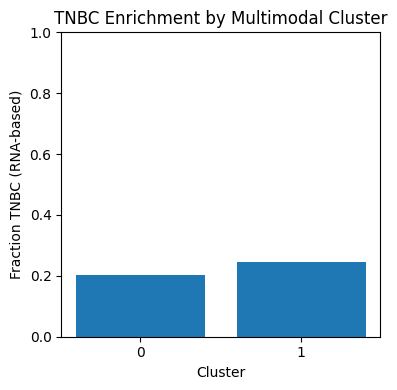

In [44]:
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

cont = pd.crosstab(df["cluster"], df["tnbc"])
_, p_value = fisher_exact(cont)

print(cont)
print("Fisher exact p-value:", p_value)

plt.figure(figsize=(4,4))
plt.bar(summary.index.astype(str), summary["TNBC_fraction"])
plt.ylabel("Fraction TNBC (RNA-based)")
plt.xlabel("Cluster")
plt.title("TNBC Enrichment by Multimodal Cluster")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [46]:
mki67 = rnaseq_named.loc["MKI67"].values

df["mki67"] = mki67

df.groupby("cluster")["mki67"].median()


,mki67
cluster,
0,4383.5
1,5532.0


In [48]:
from scipy.stats import mannwhitneyu

mki67 = rnaseq_named.loc["MKI67"].values

stat, p_mki = mannwhitneyu(
    mki67[clusters_aligned == 0],
    mki67[clusters_aligned == 1],
    alternative="two-sided"
)

print("MKI67 p-value:", p_mki)


MKI67 p-value: 0.08859956308697547


/tmp/ipython-input-4228903726.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


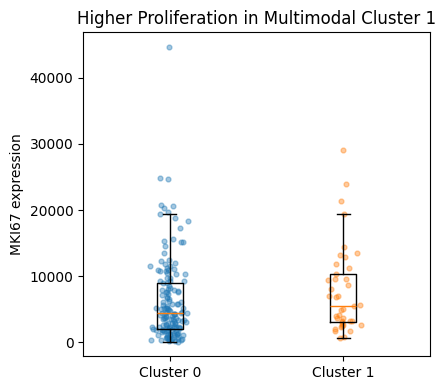

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# extract MKI67
mki67 = rnaseq_named.loc["MKI67"].values

# split by cluster
mki67_c0 = mki67[clusters_aligned == 0]
mki67_c1 = mki67[clusters_aligned == 1]

plt.figure(figsize=(4.5, 4))

# boxplot
plt.boxplot(
    [mki67_c0, mki67_c1],
    labels=["Cluster 0", "Cluster 1"],
    showfliers=False
)

# jittered points
x0 = np.random.normal(1, 0.04, size=len(mki67_c0))
x1 = np.random.normal(2, 0.04, size=len(mki67_c1))

plt.scatter(x0, mki67_c0, alpha=0.4, s=12)
plt.scatter(x1, mki67_c1, alpha=0.4, s=12)

plt.ylabel("MKI67 expression")
plt.title("Higher Proliferation in Multimodal Cluster 1")

plt.tight_layout()
plt.show()


/tmp/ipython-input-3180578515.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


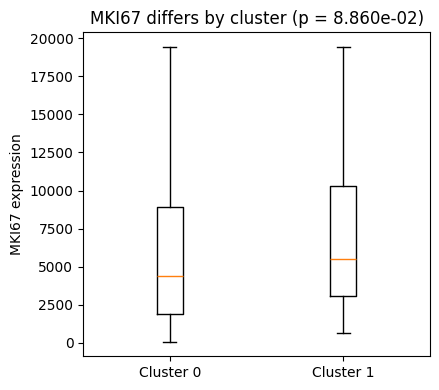

In [50]:
plt.figure(figsize=(4.5, 4))

plt.boxplot(
    [mki67_c0, mki67_c1],
    labels=["Cluster 0", "Cluster 1"],
    showfliers=False
)

plt.ylabel("MKI67 expression")
plt.title(f"MKI67 differs by cluster (p = {p_mki:.3e})")

plt.tight_layout()
plt.show()


In [51]:
from scipy.stats import mannwhitneyu

# MKI67 expression
mki67 = rnaseq_named.loc["MKI67"].values

# split by cluster
mki67_c0 = mki67[clusters_aligned == 0]
mki67_c1 = mki67[clusters_aligned == 1]

# Mann–Whitney U test (two-sided)
u_stat, p_mki = mannwhitneyu(
    mki67_c0,
    mki67_c1,
    alternative="two-sided"
)

print("Mann–Whitney U statistic:", u_stat)
print("MKI67 p-value:", p_mki)


Mann–Whitney U statistic: 2575.0
MKI67 p-value: 0.08859956308697547


In [47]:
immune_genes = ["CD3D", "CD3E", "CD8A", "GZMB"]
immune_genes = [g for g in immune_genes if g in rnaseq_named.index]

immune_score = rnaseq_named.loc[immune_genes].mean(axis=0)

df["immune_score"] = immune_score.values
df.groupby("cluster")["immune_score"].median()


,immune_score
cluster,
0,342.25
1,359.00
